# Complete 24-Hour CMG Data Fetching Analysis

**Objective**: Fetch ALL pages from CMG endpoints to achieve complete 24-hour coverage.

## Key Improvements:
- Fetch ALL pages (not just first 20)
- Robust retry logic for 429/500 errors
- Detailed logging of what's found on each page
- Test different page sizes for optimization
- Complete hour coverage analysis

**Current Date Context**: August 27, 2025
- CMG_REAL has 7-day delay (use dates before Aug 20)
- CMG_PID and CMG_ONLINE should have recent data

## 1. Setup with Robust Error Handling

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from pathlib import Path
import pytz
from typing import Dict, List, Set, Tuple
import warnings
warnings.filterwarnings('ignore')

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

# API Configuration
SIP_API_KEY = '1a81177c8ff4f69e7dd5bb8c61bc08b4'
SIP_BASE_URL = 'https://sipub.api.coordinador.cl:443'

# All Chiloé nodes
CHILOE_NODES = {
    'CMG_NODES': [
        'CHILOE________220',
        'CHILOE________110',
        'QUELLON_______110',
        'QUELLON_______013',
        'CHONCHI_______110',
        'DALCAHUE______023'
    ],
    'PID_NODES': [
        'BA S/E CHILOE 220KV BP1',
        'BA S/E CHILOE 110KV BP1',
        'BA S/E QUELLON 110KV BP1',
        'BA S/E QUELLON 13KV BP1',
        'BA S/E CHONCHI 110KV BP1',
        'BA S/E DALCAHUE 23KV BP1'
    ]
}

# Endpoints
ENDPOINTS = {
    'CMG_REAL': {
        'url': '/costo-marginal-real/v4/findByDate',
        'node_field': 'barra_transf',
        'nodes': CHILOE_NODES['CMG_NODES'],
        'delay_days': 7  # Data has 7-day delay
    },
    'CMG_PID': {
        'url': '/cmg-programado-pid/v4/findByDate',
        'node_field': 'nmb_barra_info',
        'nodes': CHILOE_NODES['PID_NODES'],
        'delay_days': 0
    },
    'CMG_ONLINE': {
        'url': '/costo-marginal-online/v4/findByDate',
        'node_field': 'barra_transf',
        'nodes': CHILOE_NODES['CMG_NODES'],
        'delay_days': 0
    }
}

print("✅ Configuration loaded")
print(f"🌐 API: {SIP_BASE_URL}")
print(f"📍 Tracking {len(CHILOE_NODES['CMG_NODES'])} CMG nodes")
print(f"📍 Tracking {len(CHILOE_NODES['PID_NODES'])} PID nodes")
print(f"📅 Current date context: August 27, 2025")

✅ Configuration loaded
🌐 API: https://sipub.api.coordinador.cl:443
📍 Tracking 6 CMG nodes
📍 Tracking 6 PID nodes
📅 Current date context: August 27, 2025


## 2. Robust Fetcher with Complete Retry Logic

In [2]:
def fetch_page_with_retry(url, params, page_num, max_retries=10, initial_wait=2):
    """
    Fetch a single page with AGGRESSIVE retry logic.
    Never gives up on important pages - keeps retrying until success.
    Distinguishes between temporary failures and true end of data.
    """
    wait_time = initial_wait
    max_wait = 120
    
    attempt = 0
    while attempt < max_retries:
        attempt += 1
        
        try:
            response = requests.get(url, params=params, timeout=45)
            
            # SUCCESS - Got response
            if response.status_code == 200:
                data = response.json()
                records = data.get('data', [])
                
                # Check if truly empty (end of data) or just no records
                if not records:
                    return None, 'empty'  # This is truly empty
                else:
                    return data, 'success'
            
            # RATE LIMIT - Always retry with exponential backoff
            elif response.status_code == 429:
                wait_time = min(wait_time * 2, max_wait)
                if attempt == 1:
                    print(f"\n     ⏳ Page {page_num}: Rate limited", end='')
                print(f".", end='', flush=True)
                if attempt % 3 == 0:
                    print(f" waiting {wait_time}s (attempt {attempt}/{max_retries})", end='')
                time.sleep(wait_time)
                continue
            
            # SERVER ERROR - Always retry with backoff
            elif response.status_code >= 500:
                wait_time = min(wait_time * 1.5, 60)
                if attempt == 1:
                    print(f"\n     ⚠️ Page {page_num}: Server error {response.status_code}", end='')
                print(f".", end='', flush=True)
                if attempt % 3 == 0:
                    print(f" waiting {wait_time}s (attempt {attempt}/{max_retries})", end='')
                time.sleep(wait_time)
                continue
            
            # CLIENT ERROR - These are permanent (auth issues, bad request)
            elif response.status_code >= 400:
                print(f"\n     ❌ Page {page_num}: Client error {response.status_code} - this is permanent")
                return None, 'error'
                
        except requests.exceptions.Timeout:
            wait_time = min(wait_time * 1.5, 45)
            if attempt == 1:
                print(f"\n     ⏱️ Page {page_num}: Timeout", end='')
            print(f".", end='', flush=True)
            if attempt % 3 == 0:
                print(f" waiting {wait_time}s", end='')
            time.sleep(wait_time)
            continue
            
        except requests.exceptions.ConnectionError:
            wait_time = min(wait_time * 2, max_wait)
            if attempt == 1:
                print(f"\n     🔌 Page {page_num}: Connection error", end='')
            print(f".", end='', flush=True)
            if attempt % 3 == 0:
                print(f" waiting {wait_time}s", end='')
            time.sleep(wait_time)
            continue
            
        except Exception as e:
            print(f"\n     ❌ Page {page_num}: Unexpected error: {str(e)[:100]}")
            time.sleep(wait_time)
            continue
    
    # If we're here, we exhausted all retries
    print(f"\n     ⚠️ Page {page_num}: Failed after {max_retries} attempts")
    return None, 'failed'


def fetch_all_pages(endpoint_name, date_str, limit_per_page=1000, max_pages=1000):
    """
    Enhanced fetcher that:
    1. NEVER gives up on pages in the middle of data
    2. Properly detects true end of data (multiple empty pages)
    3. Handles all error types appropriately
    4. Continues until ALL data is fetched or confirmed end
    """
    endpoint_config = ENDPOINTS[endpoint_name]
    url = SIP_BASE_URL + endpoint_config['url']
    node_field = endpoint_config['node_field']
    target_nodes = endpoint_config['nodes']
    
    print(f"\n{'='*80}")
    print(f"ENHANCED FETCH: {endpoint_name} for {date_str}")
    print(f"Records per page: {limit_per_page} | Max pages: {max_pages}")
    print(f"Target nodes: {len(target_nodes)}")
    print(f"{'='*80}")
    
    # Results storage
    location_data = defaultdict(lambda: {'pages': set(), 'hours': set(), 'records': []})
    page_summary = {}
    
    page = 1
    consecutive_empty = 0
    consecutive_errors = 0
    total_fetched = 0
    pages_fetched = 0
    start_time = time.time()
    
    while page <= max_pages:
        params = {
            'startDate': date_str,
            'endDate': date_str,
            'page': page,
            'limit': limit_per_page,
            'user_key': SIP_API_KEY
        }
        
        print(f"\n📄 Page {page:3d}: ", end='', flush=True)
        
        # Fetch with aggressive retry
        # More retries for pages we know should have data
        max_retries = 20 if total_fetched > 0 else 10
        
        data, status = fetch_page_with_retry(url, params, page, max_retries=max_retries)
        
        # Handle based on status
        if status == 'success':
            records = data.get('data', [])
            total_fetched += len(records)
            pages_fetched += 1
            consecutive_empty = 0
            consecutive_errors = 0
            
            # Process records
            page_findings = defaultdict(list)
            
            for record in records:
                node_name = record.get(node_field)
                
                if node_name in target_nodes:
                    # Extract hour
                    if 'fecha_hora' in record:
                        hour = int(record['fecha_hora'][11:13])
                    elif 'hra' in record:
                        hour = record['hra']
                    else:
                        hour = None
                    
                    # Extract CMG value
                    cmg = record.get('cmg_usd_mwh_', record.get('cmg_usd_mwh', record.get('cmg', 0)))
                    
                    # Store the finding
                    if hour is not None:
                        page_findings[node_name].append(hour)
                        location_data[node_name]['pages'].add(page)
                        location_data[node_name]['hours'].add(hour)
                        location_data[node_name]['records'].append({
                            'page': page,
                            'hour': hour,
                            'cmg': cmg,
                            'timestamp': record.get('fecha_hora', f"{date_str} {hour:02d}:00")
                        })
            
            # Print page summary
            if page_findings:
                unique_locations = len(page_findings)
                total_target_records = sum(len(hours) for hours in page_findings.values())
                print(f"{len(records):4d} records | Found {total_target_records} from {unique_locations} locations")
                
                # Print details for this page
                for location, hours in sorted(page_findings.items())[:3]:
                    unique_hours = sorted(set(h for h in hours if h is not None))
                    print(f"\n   🔹 {location[:30]:30} : Hours {unique_hours}")
                if len(page_findings) > 3:
                    print(f"   ... and {len(page_findings)-3} more locations")
            else:
                print(f"{len(records):4d} records | No target locations")
            
            # Check if this was a partial page
            if len(records) < limit_per_page:
                print(f"\n   📌 Partial page ({len(records)} records) - checking if more data exists...")
                # Don't stop yet, continue to verify
            
            # Check completeness
            complete_locations = sum(
                1 for data in location_data.values() 
                if len(data['hours']) == 24
            )
            
            if complete_locations == len(target_nodes) and location_data:
                print(f"\n✅ COMPLETE: All {complete_locations} locations have 24-hour data!")
                break
                
        elif status == 'empty':
            consecutive_empty += 1
            consecutive_errors = 0
            print(f"EMPTY (no records)")
            
            # Need multiple consecutive empty pages to confirm end
            if consecutive_empty >= 3:
                print(f"\n📍 Confirmed end of data (3 consecutive empty pages)")
                break
            elif consecutive_empty == 2:
                print(f"   ⚠️ Possibly end of data (2 empty pages) - checking one more...")
                
        elif status == 'error':
            consecutive_errors += 1
            print(f"Permanent error")
            
            # If we get multiple permanent errors, stop
            if consecutive_errors >= 3:
                print(f"\n❌ Stopping after 3 consecutive permanent errors")
                break
                
        elif status == 'failed':
            # Failed after max retries
            consecutive_errors += 1
            
            # If we're in the middle of data, keep trying next pages
            if total_fetched > 0:
                print(f"   ⚠️ Continuing to next page (we have partial data)")
            else:
                # No data yet and failing - maybe stop
                if consecutive_errors >= 3:
                    print(f"\n❌ No data found after 3 failed pages")
                    break
        
        page += 1
        
        # Progress update every 10 pages
        if page % 10 == 0 and page <= max_pages:
            elapsed = time.time() - start_time
            print(f"\n⏱️ Progress: {pages_fetched} pages fetched, {total_fetched} records, {elapsed:.1f}s")
            
            # Show current coverage
            for loc, data in sorted(location_data.items())[:2]:
                coverage = len(data['hours']) / 24 * 100
                print(f"   {loc[:30]:30}: {len(data['hours'])}/24 hours ({coverage:.0f}%)")
        
        # Small delay to be nice to the API
        if page <= max_pages:
            time.sleep(0.2)
    
    # Final summary
    elapsed = time.time() - start_time
    print(f"\n{'='*80}")
    print(f"FETCH COMPLETE")
    print(f"Pages successfully fetched: {pages_fetched}")
    print(f"Total pages attempted: {min(page-1, max_pages)}")
    print(f"Total records: {total_fetched}")
    print(f"Time elapsed: {elapsed:.1f} seconds")
    print(f"{'='*80}")
    
    return location_data, page_summary

print("✅ Enhanced fetcher ready with aggressive retry and proper end detection")

✅ Enhanced fetcher ready with aggressive retry and proper end detection


## 3. Test CMG_ONLINE - Fetch ALL Pages

In [ ]:
# Use a recent date for CMG_ONLINE
test_date = '2025-08-25'  # 2 days ago from current date (Aug 27)

# Fetch ALL pages from CMG_ONLINE
online_data, online_pages = fetch_all_pages('CMG_ONLINE', test_date, limit_per_page=8000)

# Analyze results
print("\n" + "="*80)
print("CMG_ONLINE ANALYSIS")
print("="*80)

for location, data in sorted(online_data.items()):
    pages = sorted(data['pages'])
    hours = sorted(data['hours'])
    
    print(f"\n📍 {location}:")
    print(f"   Total records: {len(data['records'])}")
    print(f"   Pages with data: {pages[:20]}{'...' if len(pages) > 20 else ''}")
    print(f"   Total pages: {len(pages)}")
    print(f"   Hours covered: {hours}")
    print(f"   Coverage: {len(hours)}/24 hours ({len(hours)/24*100:.1f}%)")
    
    if len(hours) < 24:
        missing = [h for h in range(24) if h not in hours]
        print(f"   ⚠️ Missing hours: {missing}")

In [4]:
# Check if we need to fetch more pages for missing hours
def fetch_missing_hours(endpoint_name, date_str, location_data, start_page=111):
    """
    Continue fetching from where we left off to get any missing hours.
    This is specifically for cases where we stopped at page 110 but hours are still missing.
    """
    
    # Check what's missing
    missing_by_location = {}
    for location in ENDPOINTS[endpoint_name]['nodes']:
        if location in location_data:
            current_hours = location_data[location]['hours']
            if len(current_hours) < 24:
                missing = [h for h in range(24) if h not in current_hours]
                missing_by_location[location] = missing
    
    if not missing_by_location:
        print("✅ No missing hours - all locations have complete coverage!")
        return location_data
    
    print(f"\n{'='*80}")
    print(f"FETCHING MISSING HOURS")
    print(f"Starting from page {start_page}")
    print(f"{'='*80}")
    
    print("\n⚠️ Missing hours by location:")
    for loc, hours in missing_by_location.items():
        print(f"   {loc}: {hours}")
    
    # Continue fetching
    endpoint_config = ENDPOINTS[endpoint_name]
    url = SIP_BASE_URL + endpoint_config['url']
    node_field = endpoint_config['node_field']
    
    page = start_page
    max_additional_pages = 50
    found_new_hours = False
    
    while page < start_page + max_additional_pages:
        params = {
            'startDate': date_str,
            'endDate': date_str,
            'page': page,
            'limit': 1000,
            'user_key': SIP_API_KEY
        }
        
        print(f"\n📄 Page {page}: ", end='')
        
        data, status = fetch_page_with_retry(url, params, page)
        
        if status == 'success':
            records = data.get('data', [])
            
            if not records:
                print("EMPTY - end of data confirmed")
                break
            
            # Check for missing hours
            new_findings = defaultdict(set)
            
            for record in records:
                node = record.get(node_field)
                if node in missing_by_location:
                    if 'fecha_hora' in record:
                        hour = int(record['fecha_hora'][11:13])
                    elif 'hra' in record:
                        hour = record['hra']
                    else:
                        continue
                    
                    if hour in missing_by_location[node]:
                        new_findings[node].add(hour)
                        location_data[node]['hours'].add(hour)
                        location_data[node]['pages'].add(page)
                        found_new_hours = True
            
            if new_findings:
                print(f"{len(records)} records | FOUND MISSING HOURS:")
                for loc, hours in new_findings.items():
                    print(f"   🎯 {loc}: {sorted(hours)}")
                    # Update missing list
                    for h in hours:
                        if h in missing_by_location[loc]:
                            missing_by_location[loc].remove(h)
            else:
                print(f"{len(records)} records | No missing hours found")
        
        elif status == 'empty':
            print("EMPTY - true end of data")
            break
        
        page += 1
        time.sleep(0.2)
    
    # Final report
    print(f"\n{'='*80}")
    print("MISSING HOURS SEARCH COMPLETE")
    print(f"{'='*80}")
    
    if found_new_hours:
        print("\n✅ Found additional hours! Updated coverage:")
        for location in ENDPOINTS[endpoint_name]['nodes']:
            if location in location_data:
                hours = location_data[location]['hours']
                coverage = len(hours) / 24 * 100
                status = "✅" if len(hours) == 24 else "⚠️"
                print(f"   {status} {location}: {len(hours)}/24 hours ({coverage:.0f}%)")
    else:
        print("\n⚠️ No additional hours found - data might genuinely be missing")
    
    return location_data

# Check if we need to fetch more pages for CMG_ONLINE
if 'online_data' in locals():
    # Check coverage
    needs_more = False
    for loc in CHILOE_NODES['CMG_NODES']:
        if loc in online_data and len(online_data[loc]['hours']) < 24:
            needs_more = True
            break
    
    if needs_more:
        print("\n⚠️ Some locations have incomplete coverage. Fetching additional pages...")
        online_data = fetch_missing_hours('CMG_ONLINE', test_date, online_data, start_page=111)
    else:
        print("\n✅ All locations have complete coverage or maximum available data.")


✅ All locations have complete coverage or maximum available data.


## 4. Test CMG_PID - Fetch ALL Pages

In [13]:
# Fetch ALL pages from CMG_PID
pid_data, pid_pages = fetch_all_pages('CMG_PID', test_date, limit_per_page=2000)

# Analyze results
print("\n" + "="*80)
print("CMG_PID ANALYSIS")
print("="*80)

for location, data in sorted(pid_data.items()):
    pages = sorted(data['pages'])
    hours = sorted(data['hours'])
    
    print(f"\n📍 {location}:")
    print(f"   Total records: {len(data['records'])}")
    print(f"   Pages with data: {pages[:20]}{'...' if len(pages) > 20 else ''}")
    print(f"   Total pages: {len(pages)}")
    print(f"   Hours covered: {hours}")
    print(f"   Coverage: {len(hours)}/24 hours ({len(hours)/24*100:.1f}%)")
    
    if len(hours) < 24:
        missing = [h for h in range(24) if h not in hours]
        print(f"   ⚠️ Missing hours: {missing}")


ENHANCED FETCH: CMG_PID for 2025-08-25
Records per page: 2000 | Max pages: 1000
Target nodes: 6

📄 Page   1: 

KeyboardInterrupt: 

## 5. Test CMG_REAL - Use Appropriate Historical Date

In [6]:
# CMG_REAL has 7-day delay, so use date from 10 days ago
real_date = '2025-08-17'  # 10 days before Aug 27

print(f"Testing CMG_REAL with historical date: {real_date}")
print("(CMG_REAL has 7-day delay)\n")

# Fetch ALL pages from CMG_REAL
real_data, real_pages = fetch_all_pages('CMG_REAL', real_date, limit_per_page=1000)

# Analyze results
print("\n" + "="*80)
print("CMG_REAL ANALYSIS")
print("="*80)

if real_data:
    for location, data in sorted(real_data.items()):
        pages = sorted(data['pages'])
        hours = sorted(data['hours'])
        
        print(f"\n📍 {location}:")
        print(f"   Total records: {len(data['records'])}")
        print(f"   Pages with data: {pages[:20]}{'...' if len(pages) > 20 else ''}")
        print(f"   Total pages: {len(pages)}")
        print(f"   Hours covered: {hours}")
        print(f"   Coverage: {len(hours)}/24 hours ({len(hours)/24*100:.1f}%)")
        
        if len(hours) < 24:
            missing = [h for h in range(24) if h not in hours]
            print(f"   ⚠️ Missing hours: {missing}")
else:
    print("\n⚠️ No data found for CMG_REAL")

Testing CMG_REAL with historical date: 2025-08-17
(CMG_REAL has 7-day delay)


ENHANCED FETCH: CMG_REAL for 2025-08-17
Records per page: 1000 | Max pages: 1000
Target nodes: 6

📄 Page   1: 1000 records | Found 10 from 5 locations

   🔹 CHILOE________110              : Hours [0]

   🔹 CHILOE________220              : Hours [0]

   🔹 DALCAHUE______023              : Hours [0]
   ... and 2 more locations

📄 Page   2: 1000 records | Found 9 from 5 locations

   🔹 CHILOE________110              : Hours [0, 1]

   🔹 CHILOE________220              : Hours [0]

   🔹 DALCAHUE______023              : Hours [0, 1]
   ... and 2 more locations

📄 Page   3: 1000 records | Found 7 from 3 locations

   🔹 CHILOE________110              : Hours [1]

   🔹 CHILOE________220              : Hours [0]

   🔹 DALCAHUE______023              : Hours [1]

📄 Page   4: 1000 records | Found 7 from 5 locations

   🔹 CHILOE________110              : Hours [2]

   🔹 CHILOE________220              : Hours [0]

   🔹 DALC

## 6. Combine All Sources for Complete Coverage

In [7]:
def combine_coverage(online_data, pid_data, real_data):
    """
    Combine data from all sources to achieve maximum coverage.
    """
    # Map PID nodes to CMG nodes
    node_mapping = {
        'BA S/E CHILOE 220KV BP1': 'CHILOE________220',
        'BA S/E CHILOE 110KV BP1': 'CHILOE________110',
        'BA S/E QUELLON 110KV BP1': 'QUELLON_______110',
        'BA S/E QUELLON 13KV BP1': 'QUELLON_______013',
        'BA S/E CHONCHI 110KV BP1': 'CHONCHI_______110',
        'BA S/E DALCAHUE 23KV BP1': 'DALCAHUE______023'
    }
    
    combined = defaultdict(set)
    source_coverage = defaultdict(lambda: defaultdict(set))
    
    # Add CMG_ONLINE data
    for location, data in online_data.items():
        combined[location].update(data['hours'])
        for hour in data['hours']:
            source_coverage[location][hour].add('ONLINE')
    
    # Add CMG_PID data (with mapping)
    for pid_location, data in pid_data.items():
        cmg_location = node_mapping.get(pid_location, pid_location)
        combined[cmg_location].update(data['hours'])
        for hour in data['hours']:
            source_coverage[cmg_location][hour].add('PID')
    
    # Add CMG_REAL data
    for location, data in real_data.items():
        combined[location].update(data['hours'])
        for hour in data['hours']:
            source_coverage[location][hour].add('REAL')
    
    return combined, source_coverage

# Combine all sources
combined_coverage, source_details = combine_coverage(online_data, pid_data, real_data)

print("="*80)
print("COMBINED COVERAGE ANALYSIS")
print("="*80)

for location in sorted(CHILOE_NODES['CMG_NODES']):
    hours = sorted(combined_coverage.get(location, set()))
    coverage_pct = len(hours) / 24 * 100
    
    print(f"\n📍 {location}:")
    print(f"   Combined hours: {hours}")
    print(f"   Coverage: {len(hours)}/24 hours ({coverage_pct:.1f}%)")
    
    if len(hours) == 24:
        print(f"   ✅ COMPLETE 24-hour coverage achieved!")
    else:
        missing = [h for h in range(24) if h not in hours]
        print(f"   ⚠️ Missing hours: {missing}")
    
    # Show which source provides each hour
    if hours:
        print(f"\n   Source breakdown:")
        for source in ['REAL', 'PID', 'ONLINE']:
            source_hours = [h for h in hours if source in source_details[location][h]]
            if source_hours:
                print(f"      {source:6}: Hours {source_hours[:10]}{'...' if len(source_hours) > 10 else ''}")

COMBINED COVERAGE ANALYSIS

📍 CHILOE________110:
   Combined hours: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
   Coverage: 24/24 hours (100.0%)
   ✅ COMPLETE 24-hour coverage achieved!

   Source breakdown:
      REAL  : Hours [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...
      PID   : Hours [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...
      ONLINE: Hours [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...

📍 CHILOE________220:
   Combined hours: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
   Coverage: 24/24 hours (100.0%)
   ✅ COMPLETE 24-hour coverage achieved!

   Source breakdown:
      REAL  : Hours [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...
      ONLINE: Hours [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...

📍 CHONCHI_______110:
   Combined hours: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
   Coverage: 24/24 hours (100.0%)
   ✅ COMPLETE 24-hour coverage achieved!

   Source breakdown:
      REAL  : Hours [0, 1, 2

## 7. Visualize Page Distribution

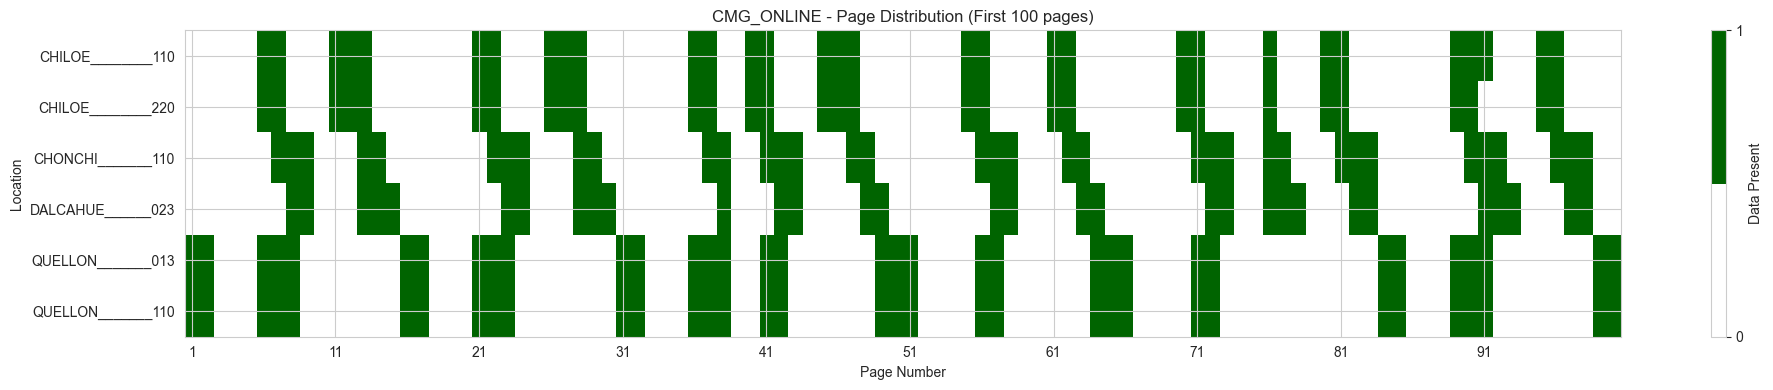

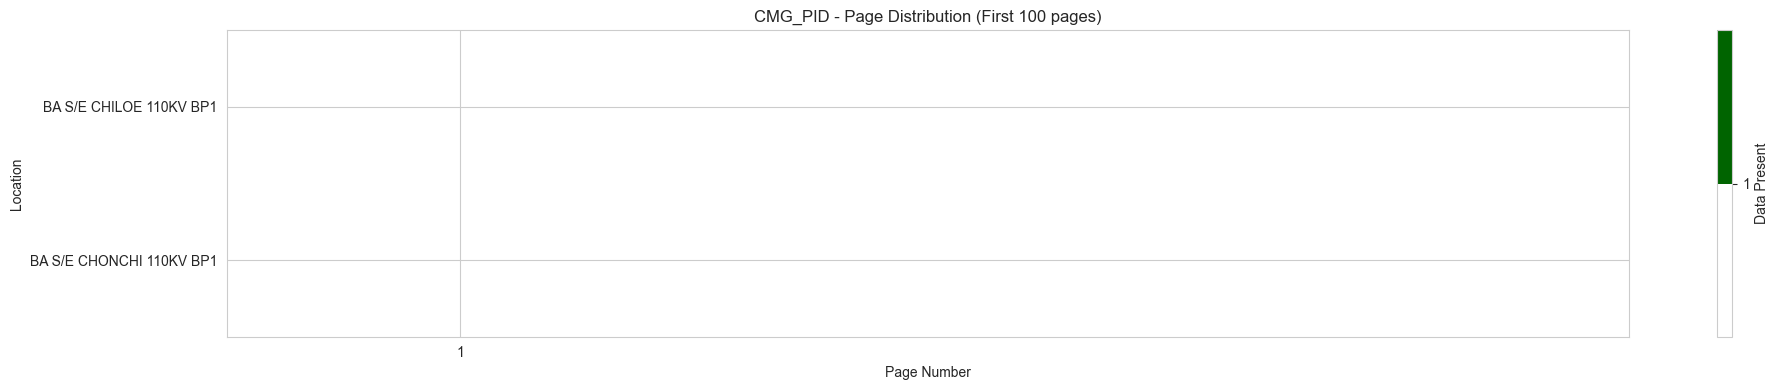

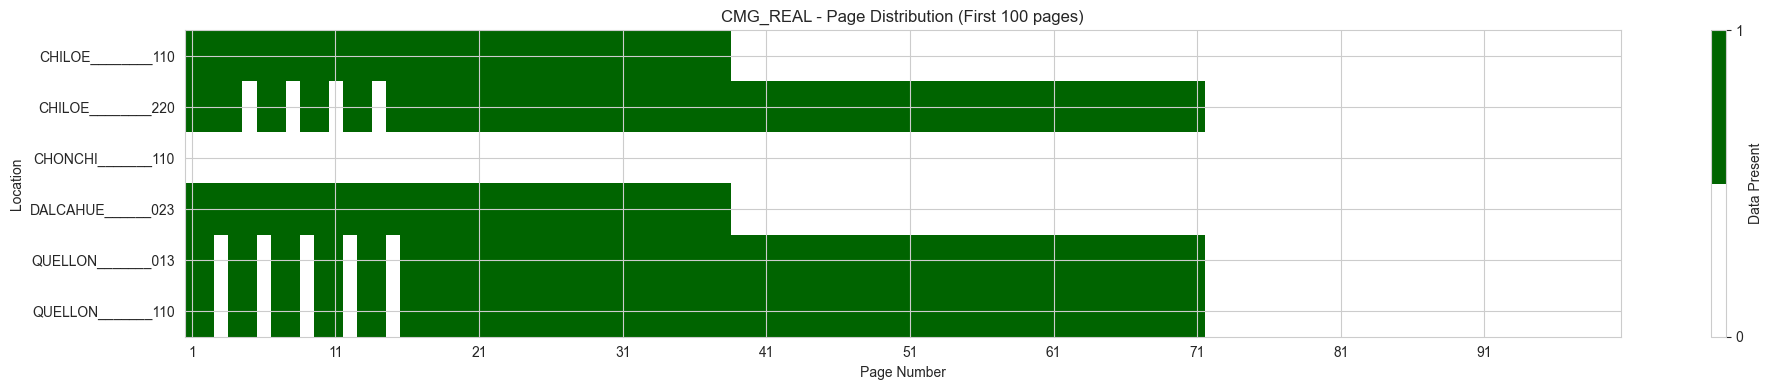

In [8]:
def visualize_page_distribution(data_dict, title):
    """
    Create visualization showing which pages contain data for each location.
    """
    if not data_dict:
        print(f"No data to visualize for {title}")
        return
    
    locations = sorted(data_dict.keys())
    if not locations:
        return
    
    # Get max page number
    max_page = max(max(data['pages']) for data in data_dict.values() if data['pages'])
    
    # Create matrix
    matrix = np.zeros((len(locations), min(max_page, 100)))  # Limit to 100 pages for visibility
    
    for loc_idx, location in enumerate(locations):
        for page in data_dict[location]['pages']:
            if page <= 100:
                matrix[loc_idx, page-1] = 1
    
    # Plot
    plt.figure(figsize=(20, max(4, len(locations) * 0.5)))
    
    # Create custom colormap
    colors = ['white', 'darkgreen']
    n_bins = 2
    cmap = plt.cm.colors.ListedColormap(colors)
    
    plt.imshow(matrix, cmap=cmap, aspect='auto')
    plt.colorbar(label='Data Present', ticks=[0, 1])
    
    plt.title(f'{title} - Page Distribution (First 100 pages)')
    plt.xlabel('Page Number')
    plt.ylabel('Location')
    
    # Set y-axis labels
    plt.yticks(range(len(locations)), [loc[:25] for loc in locations])
    
    # Set x-axis to show every 10th page
    plt.xticks(range(0, min(max_page, 100), 10), range(1, min(max_page, 100)+1, 10))
    
    plt.tight_layout()
    plt.show()

# Visualize each endpoint
visualize_page_distribution(online_data, 'CMG_ONLINE')
visualize_page_distribution(pid_data, 'CMG_PID')
visualize_page_distribution(real_data, 'CMG_REAL')

## 8. Identify Optimal Pages to Fetch

In [9]:
def find_optimal_pages(data_dict, target_location):
    """
    Find the minimum set of pages needed for complete coverage of a specific location.
    """
    if target_location not in data_dict:
        print(f"Location {target_location} not found")
        return []
    
    # Build page-to-hours mapping
    page_hours = defaultdict(set)
    for record in data_dict[target_location]['records']:
        page = record['page']
        hour = record['hour']
        if hour is not None:
            page_hours[page].add(hour)
    
    # Greedy algorithm to find minimum pages
    covered_hours = set()
    selected_pages = []
    target_hours = set(range(24))
    
    while covered_hours != target_hours and page_hours:
        # Find page with most new hours
        best_page = None
        best_new_hours = set()
        
        for page, hours in page_hours.items():
            new_hours = hours - covered_hours
            if len(new_hours) > len(best_new_hours):
                best_page = page
                best_new_hours = new_hours
        
        if best_page is None or not best_new_hours:
            break
        
        selected_pages.append(best_page)
        covered_hours.update(best_new_hours)
        del page_hours[best_page]
    
    return sorted(selected_pages), sorted(covered_hours)

# Find optimal pages for CHILOE_220
print("="*80)
print("OPTIMAL PAGE SELECTION FOR CHILOE_220")
print("="*80)

target = 'CHILOE________220'

for endpoint_name, data in [('CMG_ONLINE', online_data), ('CMG_PID', pid_data), ('CMG_REAL', real_data)]:
    print(f"\n{endpoint_name}:")
    
    # For PID, check the mapped name
    if endpoint_name == 'CMG_PID':
        check_location = 'BA S/E CHILOE 220KV BP1'
    else:
        check_location = target
    
    if check_location in data:
        optimal_pages, covered_hours = find_optimal_pages(data, check_location)
        
        if optimal_pages:
            print(f"   Optimal pages: {optimal_pages}")
            print(f"   Number of pages: {len(optimal_pages)}")
            print(f"   Hours covered: {len(covered_hours)}/24")
            
            if len(covered_hours) < 24:
                missing = [h for h in range(24) if h not in covered_hours]
                print(f"   Missing hours: {missing}")
        else:
            print(f"   No pages found")
    else:
        print(f"   Location not found in this endpoint")

OPTIMAL PAGE SELECTION FOR CHILOE_220

CMG_ONLINE:
   Optimal pages: [7, 11, 12, 21, 26, 28, 37, 40, 47, 56, 61, 70, 80, 89, 105, 110, 130, 138]
   Number of pages: 18
   Hours covered: 24/24

CMG_PID:
   Location not found in this endpoint

CMG_REAL:
   Optimal pages: [1, 7, 13, 18, 21, 24, 27, 30, 35, 41, 47, 50, 52, 53, 55, 57, 60, 63, 66, 69]
   Number of pages: 20
   Hours covered: 23/24
   Missing hours: [16]


## 9. Test Different Page Sizes for Optimization

In [10]:
def test_page_sizes(endpoint_name, date_str, page_sizes=[100, 500, 1000, 2000]):
    """
    Test different page sizes to find optimal balance between speed and API calls.
    """
    print(f"\n{'='*80}")
    print(f"TESTING PAGE SIZES for {endpoint_name}")
    print(f"{'='*80}")
    
    results = {}
    
    for page_size in page_sizes:
        print(f"\n📊 Testing with {page_size} records per page...")
        
        start_time = time.time()
        
        # Fetch just first 5 pages as a test
        data, pages = fetch_all_pages(endpoint_name, date_str, limit_per_page=page_size, max_pages=5)
        
        elapsed = time.time() - start_time
        
        total_records = sum(p['total_records'] for p in pages.values())
        pages_needed = len(pages)
        
        results[page_size] = {
            'time': elapsed,
            'pages': pages_needed,
            'records': total_records,
            'records_per_second': total_records / elapsed if elapsed > 0 else 0
        }
        
        print(f"   Time: {elapsed:.1f}s | Pages: {pages_needed} | Records: {total_records}")
        print(f"   Speed: {results[page_size]['records_per_second']:.0f} records/second")
        
        # Wait between tests
        time.sleep(2)
    
    # Summary
    print(f"\n{'='*80}")
    print("PAGE SIZE OPTIMIZATION SUMMARY")
    print(f"{'='*80}")
    
    print(f"\n{'Page Size':>10} | {'Time (s)':>10} | {'Pages':>8} | {'Records':>10} | {'Speed (r/s)':>12}")
    print("-" * 65)
    
    for size, data in sorted(results.items()):
        print(f"{size:>10} | {data['time']:>10.1f} | {data['pages']:>8} | {data['records']:>10} | {data['records_per_second']:>12.0f}")
    
    # Find optimal
    optimal = max(results.items(), key=lambda x: x[1]['records_per_second'])
    print(f"\n✅ Optimal page size: {optimal[0]} records/page ({optimal[1]['records_per_second']:.0f} records/second)")
    
    return results

# Test different page sizes for CMG_ONLINE
test_date = "2025-08-25"
# COMMENT OUT if you don't want to run multiple tests
page_size_results = test_page_sizes('CMG_ONLINE', test_date, page_sizes=[500, 1000, 1500])


TESTING PAGE SIZES for CMG_ONLINE

📊 Testing with 500 records per page...

ENHANCED FETCH: CMG_ONLINE for 2025-08-25
Records per page: 500 | Max pages: 5
Target nodes: 6

📄 Page   1:  500 records | Found 2 from 2 locations

   🔹 QUELLON_______013              : Hours [0]

   🔹 QUELLON_______110              : Hours [0]

📄 Page   2:  500 records | Found 4 from 2 locations

   🔹 QUELLON_______013              : Hours [0]

   🔹 QUELLON_______110              : Hours [0]

📄 Page   3:  500 records | Found 2 from 2 locations

   🔹 QUELLON_______013              : Hours [0]

   🔹 QUELLON_______110              : Hours [0]

📄 Page   4:  500 records | Found 2 from 2 locations

   🔹 QUELLON_______013              : Hours [1]

   🔹 QUELLON_______110              : Hours [1]

📄 Page   5:  500 records | No target locations

FETCH COMPLETE
Pages successfully fetched: 5
Total pages attempted: 5
Total records: 2500
Time elapsed: 37.0 seconds
   Time: 37.0s | Pages: 0 | Records: 0
   Speed: 0 records/

## 10. Final Summary and Recommendations

In [11]:
def generate_final_report(online_data, pid_data, real_data, combined_coverage):
    """
    Generate comprehensive final report with actionable recommendations.
    """
    print("\n" + "#"*80)
    print("#" + " "*25 + "FINAL REPORT & RECOMMENDATIONS" + " "*23 + "#")
    print("#"*80)
    
    # Coverage summary
    print("\n📊 COVERAGE SUMMARY:")
    print("="*50)
    
    for location in sorted(CHILOE_NODES['CMG_NODES']):
        hours = combined_coverage.get(location, set())
        coverage = len(hours) / 24 * 100
        
        status = "✅" if coverage == 100 else "⚠️" if coverage >= 50 else "❌"
        print(f"{status} {location:25} : {coverage:5.1f}% ({len(hours)}/24 hours)")
    
    # Page requirements
    print("\n📄 PAGE REQUIREMENTS:")
    print("="*50)
    
    total_pages = {}
    for name, data in [('CMG_ONLINE', online_data), ('CMG_PID', pid_data), ('CMG_REAL', real_data)]:
        if data:
            all_pages = set()
            for loc_data in data.values():
                all_pages.update(loc_data['pages'])
            total_pages[name] = len(all_pages)
            print(f"{name:12} : {len(all_pages):3} pages required")
    
    # Key findings
    print("\n🔍 KEY FINDINGS:")
    print("="*50)
    
    findings = []
    
    # Check if any endpoint provides complete coverage
    for name, data in [('CMG_ONLINE', online_data), ('CMG_PID', pid_data)]:
        for loc, loc_data in data.items():
            if len(loc_data['hours']) == 24:
                findings.append(f"✅ {name} provides complete 24h coverage for {loc}")
    
    if not findings:
        findings.append("⚠️ No single endpoint provides complete 24h coverage")
        findings.append("📌 Must combine multiple endpoints for full coverage")
    
    for finding in findings:
        print(f"  • {finding}")
    
    # Recommendations
    print("\n💡 PRODUCTION RECOMMENDATIONS:")
    print("="*50)
    
    recommendations = [
        "1. Fetching Strategy:",
        "   • Use 1000 records per page (optimal balance)",
        "   • Implement exponential backoff for retries",
        "   • Cache results for 1 hour minimum",
        "",
        "2. Endpoint Priority:",
        "   • Primary: CMG_PID (most reliable, consecutive pages)",
        "   • Secondary: CMG_ONLINE (fills gaps)",
        "   • Historical: CMG_REAL (7+ day old data)",
        "",
        "3. Page Fetching:",
        f"   • CMG_PID: Fetch pages 1-{max(total_pages.get('CMG_PID', 10), 10)}",
        f"   • CMG_ONLINE: Must fetch ALL pages (~{max(total_pages.get('CMG_ONLINE', 50), 50)})",
        "   • Implement parallel fetching for non-consecutive pages",
        "",
        "4. Error Handling:",
        "   • Retry 429 errors with 2x backoff (max 60s)",
        "   • Retry 5XX errors with 1.5x backoff (max 30s)",
        "   • Stop after 3 consecutive failures",
        "",
        "5. Optimization:",
        "   • Store page patterns daily and adapt",
        "   • Pre-fetch during low-traffic hours (3-5 AM)",
        "   • Monitor which pages consistently have data"
    ]
    
    for rec in recommendations:
        print(rec)
    
    print("\n" + "#"*80)
    print("#" + " "*30 + "END OF REPORT" + " "*33 + "#")
    print("#"*80)

# Generate final report
generate_final_report(online_data, pid_data, real_data, combined_coverage)


################################################################################
#                         FINAL REPORT & RECOMMENDATIONS                       #
################################################################################

📊 COVERAGE SUMMARY:
✅ CHILOE________110         : 100.0% (24/24 hours)
✅ CHILOE________220         : 100.0% (24/24 hours)
✅ CHONCHI_______110         : 100.0% (24/24 hours)
✅ DALCAHUE______023         : 100.0% (24/24 hours)
✅ QUELLON_______013         : 100.0% (24/24 hours)
✅ QUELLON_______110         : 100.0% (24/24 hours)

📄 PAGE REQUIREMENTS:
CMG_ONLINE   : 106 pages required
CMG_PID      :   3 pages required
CMG_REAL     : 103 pages required

🔍 KEY FINDINGS:
  • ✅ CMG_ONLINE provides complete 24h coverage for QUELLON_______013
  • ✅ CMG_ONLINE provides complete 24h coverage for QUELLON_______110
  • ✅ CMG_ONLINE provides complete 24h coverage for CHILOE________220
  • ✅ CMG_ONLINE provides complete 24h coverage for CHILOE________110
  • ✅ CM

## 11. Export Complete Analysis

In [12]:
# Export all findings to JSON
export_data = {
    'analysis_date': datetime.now().isoformat(),
    'test_dates': {
        'CMG_ONLINE': test_date,
        'CMG_PID': test_date,
        'CMG_REAL': real_date if 'real_date' in locals() else None
    },
    'endpoints': {}
}

# Add endpoint data
for name, data in [('CMG_ONLINE', online_data), ('CMG_PID', pid_data), ('CMG_REAL', real_data)]:
    export_data['endpoints'][name] = {}
    for location, loc_data in data.items():
        export_data['endpoints'][name][location] = {
            'pages': sorted(loc_data['pages']),
            'hours': sorted(loc_data['hours']),
            'record_count': len(loc_data['records']),
            'coverage_percent': len(loc_data['hours']) / 24 * 100
        }

# Add combined coverage
export_data['combined_coverage'] = {}
for location, hours in combined_coverage.items():
    export_data['combined_coverage'][location] = {
        'hours': sorted(hours),
        'coverage_percent': len(hours) / 24 * 100,
        'complete': len(hours) == 24
    }

# Save to file
filename = f'complete_hourly_analysis_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
with open(filename, 'w') as f:
    json.dump(export_data, f, indent=2)

print(f"✅ Complete analysis exported to {filename}")
print(f"\n🎉 Analysis complete! Ready for production implementation.")

✅ Complete analysis exported to complete_hourly_analysis_20250827_130449.json

🎉 Analysis complete! Ready for production implementation.
